# Environment Setup
Datasetthese commands TODO: org

Push a Nvidia repo to your artifact repository - (create a new repo if not available)

The "new repo" would be us-central1-docker.pkg.dev/hybrid-vertex/merlin/ below

```
sudo docker pull nvcr.io/nvidia/merlin/merlin-hugectr:22.06
sudo docker tag nvcr.io/nvidia/merlin/merlin-hugectr:22.06 us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06
sudo docker push us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06
docker run  -d --gpus all --rm -it -p 8888:8888 -p 8797:8787 -p 8796:8786 --ipc=host --cap-add SYS_NICE us-central1-docker.pkg.dev/hybrid-vertex/merlin/merlin-hugectr:22.06 
jupyter-lab --allow-root --ip='0.0.0.0' --NotebookApp.token=''
git clone https://github.com/NVIDIA-Merlin/Merlin.git


docker run  -d --gpus all --rm -it -p 8888:8888 -p 8797:8787 -p 8796:8786 --ipc=host --cap-add SYS_NICE nvcr.io/nvidia/merlin/merlin-hugectr:22.06 
```


# Training with Merlin

Spotify example

The goal of this notebook is todo

based heavily on [this](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb) NVIDIA resource


Data is loaded from BQ - to parquet using the job configuration below

```
BUCKET = 'gs://spotify-builtin-2t'
PROJECT = 'hybrid-vertex'
DATASET_ID = 'spotify_train_3'
TABLE = 'train_flatten'
TABLE_SMALL = 'train_json_export_table_small'
LOCATION = 'us-central1'

from google.cloud import bigquery
client = bigquery.Client()

destination_uri = f"{BUCKET}/train_data_parquet/*.snappy.parquet"
dataset_ref = bigquery.DatasetReference(PROJECT, DATASET_ID)
table_ref = dataset_ref.table(TABLE)
job_config = bigquery.job.ExtractJobConfig()
job_config.destination_format = bigquery.DestinationFormat.PARQUET
extract_job = client.extract_table(
    table_ref,
    destination_uri,
    job_config=job_config,
    # Location must match that of the source table.
    location=LOCATION,
)  # API request
extract_job.result()  # Waits for job to complete.
```


Info on the data

* #### track_uri_seed counts: 2249561
* #### artist_uri_seed counts: 294110
* #### album_uri_seed counts: 730377

In [7]:
# !pip install gcsfs gsutil tensorflow

In [2]:
import os
import nvtabular as nvt
from time import time

# disable INFO and DEBUG logging everywhere
import logging

logging.disable(logging.WARNING)

from nvtabular.ops import (
    Categorify,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
)
import nvtabular.ops as ops

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf

# for running this example on CPU, comment out the line below
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2022-07-16 21:45:23.365573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 21:45:23.366393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 21:45:23.366653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 21:45:23.410406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Install package to access gcs data

In [3]:
BUCKET = 'gs://spotify-builtin-2t'
PROJECT = 'hybrid-vertex'
DATASET_ID = 'spotify_train_3'
TABLE = 'train_flatten'
TABLE_SMALL = 'train_json_export_table_small'
LOCATION = 'us-central1'
# 000000000000.snappy.parquet - example record output
train = nvt.Dataset(f"{BUCKET}/train_data_parquet/0000000000**.snappy.parquet")
valid = nvt.Dataset(f"{BUCKET}/validation_data_parquet/00000000000*.snappy.parquet")

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


## Use `cardinality_memory_limit` 

```
cardinality_memory_limit: int or str, default None
    Upper limit on the "allowed" memory usage of the internal DataFrame and Table objects
    used to store unique categories. By default, this limit is 12.5% of the total memory.
    Note that this argument is meant as a guide for internal optimizations and UserWarnings
    within NVTabular, and does not guarantee that the memory limit will be satisfied.
```

In [4]:
item_id = ["track_uri_can"] >> Categorify() >> ops.TagAsItemID() >> ops.AddMetadata(tags=["user_item"])
# playlist_id = ["pid"] >> Categorify() >> TagAsUserID() 


item_features_cat = ['artist_name_can',
        'track_name_can',
        'artist_genres_can',
    ]
item_features_cont = ['duration_ms_can',
        'track_pop_can',
        'artist_pop_can',
        'artist_followers_can',
    ]

playlist_features_cat = ['artist_name_seed_track',
        'artist_uri_seed_track',
        'track_name_seed_track',
        'track_uri_seed_track',
        'album_name_seed_track',
        'album_uri_seed_track',
        'artist_genres_seed_track',
        'description_pl',
        'name',
        'collaborative',
    ]

playlist_features_cont = [
        'duration_seed_track',
        'track_pop_seed_track',
        'artist_pop_seed_track',
        'artist_followers_seed_track',
        'duration_ms_seed_pl',
        'n_songs_pl',
        'num_artists_pl',
        'num_albums_pl',
    ]

#subset of features to be tagged
seq_feats_cont = [
        'duration_ms_songs_pl',
        'artist_pop_pl',
        'artists_followers_pl',
        'track_pop_pl',
    ]

seq_feats_cat = [
        'artist_name_pl',
        'track_uri_pl',
        'track_name_pl',
        'album_name_pl',
        'artist_genres_pl',
    ]

CAT = playlist_features_cat + item_features_cat
CONT = item_features_cont + playlist_features_cont

item_feature_cat_node = item_features_cat >> nvt.ops.FillMissing()>> Categorify() >> TagAsItemFeatures()

item_feature_cont_node =  item_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsItemFeatures()

playlist_feature_cat_node = playlist_features_cat >> nvt.ops.FillMissing() >> Categorify() >> TagAsUserFeatures() 

playlist_feature_cont_node = playlist_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures()

playlist_feature_cat_seq_node = seq_feats_cat >> nvt.ops.FillMissing() >> Categorify() >> TagAsUserFeatures() >> nvt.ops.AddTags(Tags.SEQUENCE) 

playlist_feature_cont_seq_node = seq_feats_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures() >> nvt.ops.AddTags(Tags.SEQUENCE)

In [5]:
# define a workflow
output = item_id + item_feature_cat_node + item_feature_cont_node + playlist_feature_cat_node + playlist_feature_cont_node + playlist_feature_cat_seq_node + playlist_feature_cont_seq_node
workflow = nvt.Workflow(output)

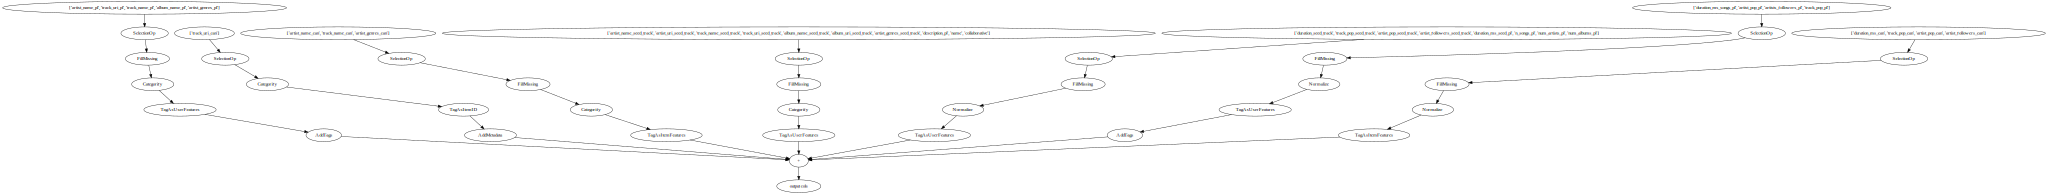

In [6]:
output.graph

In [14]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", None)

valid.to_ddf().head(1)

,name,collaborative,pid,modified_at,row_number,pid_pos_id,pos_can,artist_name_can,track_uri_can,album_uri_can,...,pos_pl,artist_name_pl,track_uri_pl,track_name_pl,duration_ms_songs_pl,album_name_pl,artist_pop_pl,artists_followers_pl,track_pop_pl,artist_genres_pl
0,Bachatas,false,110570,1402531200,1,110570-19,19,Antony Santos,spotify:track:1QY9XJBQOcn3IK5pRLcBOO,spotify:album:0MH8l6reBKR0XiruVFbfqF,...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]","[Anthony Santos, Aventura, Anthony Santos, Anthony Santos, Anthony Santos, Antony Santos, Antony Santos, El Varon de la bachata, Anthony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos, Antony Santos]","[spotify:track:53orRX6MudB9jhW0sKZWhW, spotify:track:1IdSPagRNE4i6cr6I8QBYD, spotify:track:6euDBuLIZBxCkVtp4nDaH2, spotify:track:2VJbILxAug6exqbL3PIcwl, spotify:track:59ATfWn17IAgrOAdY4NYbi, spotify:track:6WQx5OQx4hiF1CfAmcW0pI, spotify:track:2cKGzCcBEnN9BmhR1FOvRM, spotify:track:4b1ULLyRgU6FZhb9yQ7E1D, spotify:track:1uDBAmQziJZi8U5KTW31RW, spotify:track:1sg7s8xWr14UJ1vqIilqot, spotify:track:3mAsGaP2iww8IrFOeYcQxw, spotify:track:55VkPG0F93r4gYkYXBetfE, spotify:track:1soZPkNYncKsVnSk18OGTP, spotify:track:1ARBfSAwF3zDJMsBRSKik3, spotify:track:6WQx5OQx4hiF1CfAmcW0pI, spotify:track:6xRna2ZXwaiUN39EyDHFu2, spotify:track:7AO5llDSXH7lzr3T1K02E4, spotify:track:0PWL8Nxk9tekRswIeTNMJX, spotify:track:0OrRg7Aa1aJvysYPVOJRHJ]","[Creiste, Ciego De Amor - Featuring Anthony Santos, Me Enamoro, Golpes en el corazon, Me quiere la otra, Lloro, Matame, No Es Brujeria, Vete Y Aléjate De Mí, Por Mi Timedez, Sone Con Ella, Pegame Tu Vicio, Yo Me Muero Por Ti, Ay Amor, Lloro, Ay! Ven - Bachata, Mi Primera Vez, Consejo De Padre, Ay, Ay, Ay]","[257463.0, 307933.0, 258064.0, 295600.0, 277253.0, 339480.0, 208586.0, 248600.0, 274645.0, 282626.0, 277253.0, 372733.0, 392695.0, 317813.0, 339480.0, 279360.0, 269280.0, 358666.0, 334533.0]","[Creiste, God's Project, Me Enamoro, Vuelve, Vuelve, Lloro, Lloro, Alma Perdida, 25 Grandes Exitos, Aqui Esta La Bachata Vol. 2, Como Te Voy A Dejar, Enamorado, La Batalla, El Mayimbe Vuelve En Vivo, Lloro, Ay! Ven, Lloro, Sabor Latino, El Mayimbe Vuelve En Vivo]","[65.0, 82.0, 65.0, 65.0, 65.0, 65.0, 65.0, 46.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0, 65.0]","[660113.0, 5632583.0, 660113.0, 660113.0, 660113.0, 0.0, 0.0, 81821.0, 660113.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[54.0, 64.0, 33.0, 0.0, 0.0, 40.0, 48.0, 55.0, 0.0, 41.0, 49.0, 56.0, 51.0, 35.0, 40.0, 38.0, 39.0, 26.0, 33.0]","['bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'latin', 'latin hip hop', 'latin pop', 'trap latino', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'latin', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical', 'bachata', 'bachata dominicana', 'dominican pop', 'latin', 'tropical']"


Now set the output buckets for the validation and training

In [22]:
output_path = os.path.join(BUCKET, "merlin-processed")
output_train_dir = os.path.join(output_path, 'train/')
output_valid_dir = os.path.join(output_path, 'valid/')
output_workflow_dir = os.path.join(output_path, 'workflow/')


print(f"Train data dir: {output_train_dir}\nValid data dir: {output_valid_dir}")

Train data dir: gs://spotify-builtin-2t/merlin-processed/train/
Valid data dir: gs://spotify-builtin-2t/merlin-processed/valid/


## Load and preprocess training data back to Parquet GCS
helpful resources https://cloud.google.com/compute/docs/gpus/monitor-gpus

In [17]:
%%time

time_preproc = 0
time_preproc_start = time()

workflow.fit_transform(train).to_parquet(output_path=output_train_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=100) #preserve_files=True keeps the original file sharding


time_preproc += time()-time_preproc_start

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


CPU times: user 4min 27s, sys: 3min 2s, total: 7min 29s
Wall time: 11min 26s


In [24]:
#save the workflow to disk after it has been fit
workflow.save(os.path.join(output_workflow_dir,'2t-spotify-workflow'))

In [46]:
schema = workflow.output_schema

schema
# workflow.save #todo

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,track_uri_can,"(Tags.ITEM, Tags.CATEGORICAL, user_item, Tags.ITEM_ID)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.track_uri_can.parquet,0.0,258189.0,track_uri_can,258189.0,512.0
1,artist_name_can,"(Tags.CATEGORICAL, Tags.ITEM)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.artist_name_can.parquet,0.0,57696.0,artist_name_can,57696.0,512.0
2,track_name_can,"(Tags.CATEGORICAL, Tags.ITEM)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.track_name_can.parquet,0.0,196107.0,track_name_can,196107.0,512.0
3,artist_genres_can,"(Tags.CATEGORICAL, Tags.ITEM)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.artist_genres_can.parquet,0.0,20511.0,artist_genres_can,20511.0,416.0
4,duration_ms_can,"(Tags.CONTINUOUS, Tags.ITEM)",float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,track_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,artist_pop_can,"(Tags.CONTINUOUS, Tags.ITEM)",float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,artist_followers_can,"(Tags.CONTINUOUS, Tags.ITEM)",float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,artist_name_seed_track,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.artist_name_seed_track.parquet,0.0,57557.0,artist_name_seed_track,57557.0,512.0
9,artist_uri_seed_track,"(Tags.USER, Tags.CATEGORICAL)",int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.artist_uri_seed_track.parquet,0.0,58165.0,artist_uri_seed_track,58165.0,512.0


## Load and preprocess validation

In [19]:
%%time

time_preproc_start = time()
wf_valid_op = workflow.transform(valid).to_parquet(output_path=output_valid_dir, 
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=10)


time_preproc += time()-time_preproc_start

CPU times: user 8.08 s, sys: 5.59 s, total: 13.7 s
Wall time: 25.9 s


nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['artist_genres_can'].head(10)

In [44]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['collaborative'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: collaborative, dtype: int64

In [24]:
len(nvtdata)

12347

In [19]:
embeddings = ops.get_embedding_sizes(workflow)
embeddings

({'track_uri_can': (258189, 512),
  'artist_name_can': (57696, 512),
  'track_name_can': (196107, 512),
  'artist_genres_can': (20511, 416),
  'artist_name_seed_track': (57557, 512),
  'artist_uri_seed_track': (58165, 512),
  'track_name_seed_track': (195896, 512),
  'track_uri_seed_track': (257894, 512),
  'album_name_seed_track': (112919, 512),
  'album_uri_seed_track': (134740, 512),
  'artist_genres_seed_track': (20431, 415),
  'description_pl': (11574, 302),
  'name': (72117, 512),
  'collaborative': (3, 16)},
 {'artist_name_pl': (211490, 512),
  'track_uri_pl': (1621962, 512),
  'track_name_pl': (1086902, 512),
  'album_name_pl': (426100, 512),
  'artist_genres_pl': (34844, 512)})

In [26]:
print([embeddings[0][x] for x in item_feature_cat_node.output_columns.names])

[(57696, 512), (196107, 512), (20511, 416)]


In [27]:
playlist_feature_cont_node.output_columns.names

['duration_seed_track',
 'track_pop_seed_track',
 'artist_pop_seed_track',
 'artist_followers_seed_track',
 'duration_ms_seed_pl',
 'n_songs_pl',
 'num_artists_pl',
 'num_albums_pl']

# Load the processed data into a Merlin Dataset and inspect the transforms

Now that ETL is over, the workflow is saved and data is processed to the `output_path`

In [31]:
# !gcloud set project-id hybrid-vertex

/bin/bash: gcloud: command not found


In [30]:
!gsutil cp -r {output_workflow_dir} .

ServiceException: 401 Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object.


In [28]:
# load back the workflow and schema
# spotify-builtin-2t/merlin-processed/workflow/2t-spotify-workflow
workflow = nvt.Workflow.load(output_workflow_dir + "/2t-spotify-workflow")
schema = workflow.output_schema
embeddings = ops.get_embedding_sizes(workflow)
embeddings

FileNotFoundError: b/spotify-builtin-2t/o/merlin-processed%2Fworkflow%2F%2F2t-spotify-workflow%2Fmetadata.json

In [10]:
from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset as MerlinDataset

train = MerlinDataset(output_train_dir + "/*.parquet", schema=schema)
valid = MerlinDataset(output_valid_dir + "/*.parquet", schema=schema)

#look at output
schema = train.schema

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


In [12]:
# schema = schema.select_by_tag([Tags.ITEM_ID, Tags.ITEM, Tags.USER])

In [13]:
schema.column_names

['track_uri_can',
 'artist_name_can',
 'track_name_can',
 'artist_genres_can',
 'duration_ms_can',
 'track_pop_can',
 'artist_pop_can',
 'artist_followers_can',
 'artist_name_seed_track',
 'artist_uri_seed_track',
 'track_name_seed_track',
 'track_uri_seed_track',
 'album_name_seed_track',
 'album_uri_seed_track',
 'artist_genres_seed_track',
 'description_pl',
 'name',
 'collaborative',
 'duration_seed_track',
 'track_pop_seed_track',
 'artist_pop_seed_track',
 'artist_followers_seed_track',
 'duration_ms_seed_pl',
 'n_songs_pl',
 'num_artists_pl',
 'num_albums_pl',
 'artist_name_pl',
 'track_uri_pl',
 'track_name_pl',
 'album_name_pl',
 'artist_genres_pl',
 'duration_ms_songs_pl',
 'artist_pop_pl',
 'artists_followers_pl',
 'track_pop_pl']

Direct quote from [here](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb)

### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scalable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

### Building the Model
Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.

In [18]:
# format embeddings
embeddings_all = embeddings[0]
embeddings_all.update(embeddings[1])
embeddings_all
# embeddings_all.keys()
emb_dims = {}
for k in list(embeddings_all.keys()):
    emb_dims.update({k: embeddings_all[k][1]})
emb_dims

{'track_uri_can': 512,
 'artist_name_can': 512,
 'track_name_can': 512,
 'artist_genres_can': 416,
 'artist_name_seed_track': 512,
 'artist_uri_seed_track': 512,
 'track_name_seed_track': 512,
 'track_uri_seed_track': 512,
 'album_name_seed_track': 512,
 'album_uri_seed_track': 512,
 'artist_genres_seed_track': 415,
 'description_pl': 302,
 'name': 512,
 'collaborative': 16,
 'artist_name_pl': 512,
 'track_uri_pl': 512,
 'track_name_pl': 512,
 'album_name_pl': 512,
 'artist_genres_pl': 512}

In [53]:
model = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    # item_tower=mm.MLPBlock([128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(embedding_dims=emb_dims, combiner='mean', infer_embedding_sizes_multiplier=3.0),
)

Let's explain the parameters in the TwoTowerModel():

* no_activation_last_layer: when set True, no activation is used for top hidden layer. Learn more here.
* infer_embedding_sizes: when set True, automatically defines the embedding dimension from the feature cardinality in the schema

**Metrics:**

The following information retrieval metrics are used to compute the Top-10 accuracy of recommendation lists containing all items:

* **Normalized Discounted Cumulative Gain (NDCG@10)**: NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

* **Recall@10:** Also known as HitRate@n when there is only one relevant item in the recommendation list. Recall just verifies whether the relevant item is among the top-n items.

We need to initialize the dataloaders.

In [55]:
# %%time

# model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(10), mm.NDCGAt(10)])
# model.fit(train, validation_data=valid, batch_size=8, epochs=3)

## Appendix

In [15]:
?mm.YoutubeDNNRetrievalModel

Signature:
mm.YoutubeDNNRetrievalModel(
    schema: merlin.schema.schema.Schema,
    max_seq_length: int,
    aggregation: str = 'concat',
    top_block: merlin.models.tf.blocks.core.base.Block = MLPBlock(
  (layers): List(
    (0): _Dense(
      (dense): Dense(64, activation=relu, use_bias=True)
    )
  )
),
    l2_normalization: bool = True,
    extra_pre_call: Union[merlin.models.tf.blocks.core.base.Block, NoneType] = None,
    task_block: Union[merlin.models.tf.blocks.core.base.Block, NoneType] = None,
    logits_temperature: float = 1.0,
    seq_aggregator: merlin.models.tf.blocks.core.base.Block = SequenceAggregator(),
    sampled_softmax: bool = True,
    num_sampled: int = 100,
    min_sampled_id: int = 0,
    embedding_options: merlin.models.tf.inputs.embedding.EmbeddingOptions = EmbeddingOptions(embedding_dims=None, embedding_dim_default=64, infer_embedding_sizes=False, infer_embedding_sizes_multiplier=2.0, infer_embeddings_ensure_dim_multiple_of_8=False, embeddings_initializ

In [21]:
ytmodel = mm.YoutubeDNNRetrievalModel(schema, num_sampled=100, max_seq_length=300,  embedding_options=mm.EmbeddingOptions(embedding_dims=emb_dims)) 
ytmodel.compile(optimizer="adam")
ytmodel.fit(train, batch_size=2, epochs=10)

2022-07-16 21:54:15.380813: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB (rounded to 3321780224)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-16 21:54:15.383404: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-07-16 21:54:15.383446: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 99193, Chunks in use: 99193. 24.22MiB allocated for chunks. 24.22MiB in use in bin. 5.60MiB client-requested in use in bin.
2022-07-16 21:54:15.383456: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 25967, Chunks in use: 25967. 15.82MiB allocated for chunks. 15.82MiB in use in bin. 12.72MiB client-requested in use in bin.
2022-07-16 21:54